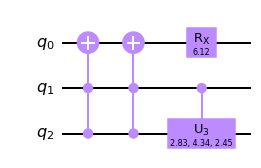

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
import sys  
sys.path.insert(0, '/Users/valerio/Documents/project_IBM_01/IBM_git/lib')
import utilities
from qiskit import IBMQ, execute
from qiskit.providers.aer import QasmSimulator
from qiskit.quantum_info import Operator
from qiskit.circuit.random import random_circuit

N_qubits = 3
t = 1.0
A = np.random.uniform(0,10, size=(2**(N_qubits)-1,2**(N_qubits)-1))
B = np.random.uniform(0,10, size=(2**(N_qubits)-1,2**(N_qubits)-1))

M = A + 1j*B
M = M + np.conjugate(M).T
H = np.zeros((2**N_qubits,2**N_qubits), dtype=complex)
H[1:,1:] = M
H[0,0] = 3.0

U = expm(1j*H*t)

c = random_circuit(num_qubits=N_qubits, depth=3)
U = Operator(c)
c.draw(output="mpl")

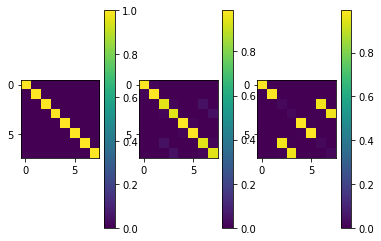

In [47]:
plt.subplot(131)
try:
    plt.imshow(np.dot(np.abs(U)**2, np.linalg.inv(np.abs(U)**2)))
    plt.colorbar()
except:
    print("nada")
plt.subplot(132)
plt.imshow(np.dot(np.abs(U)**2, np.abs(np.linalg.inv(U))**2))
plt.colorbar()
plt.subplot(133)
plt.imshow(np.abs(np.linalg.inv(U))**2)
plt.colorbar()
plt.show()

In [48]:
from sympy import Matrix
Matrix(np.linalg.inv(np.abs(U)**2))

Matrix([
[     1.0070466674721, -0.00704666747210065,                    0,                    0,                    0,                    0,                    0,                    0],
[-0.00704666747210065,      1.0070466674721,                    0,                    0,                    0,                    0,                    0,                    0],
[                   0,                    0,  -0.0247425279816728, 0.000173132360929861,                    0,                    0,     1.03178919545377, -0.00721979983303051],
[                   0,                    0, 0.000173132360929861,  -0.0247425279816728,                    0,                    0, -0.00721979983303052,     1.03178919545377],
[                   0,                    0,                    0,                    0,      1.0070466674721, -0.00704666747210065,                    0,                    0],
[                   0,                    0,                    0,                    0, -0.007046667

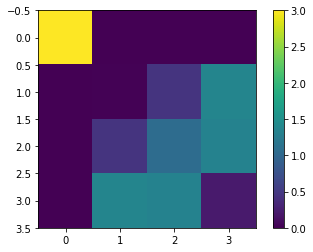

In [2]:
plt.imshow(np.abs(H))
plt.colorbar()

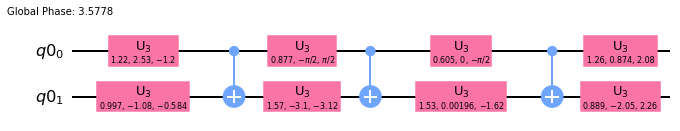

In [3]:
from qiskit import transpile, QuantumCircuit, QuantumRegister
from qiskit.quantum_info import Operator

qr = QuantumRegister(N_qubits)
circ = QuantumCircuit(qr)
circ.unitary(U, qr)
circuit = transpile(circ, basis_gates=["cx", "u3"])
circuit.draw(output="mpl")

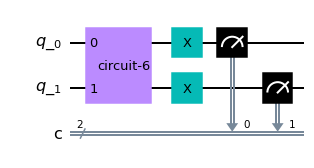

In [4]:
cal_circ, state_labels = utilities.get_calibration_circuits(circuit, method="NIC", eigenvector=N_qubits*"0")
cal_circ[-1].draw(output="mpl")

In [5]:
from qiskit.ignis.verification.tomography import state_tomography_circuits
tomo_circuits = state_tomography_circuits(circuit, qr)

In [6]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-community',
                            group='ibmquantumawards', 
                            project='open-science-22')
backend_sim_noisy_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))
backend_real_jakarta = provider.get_backend('ibmq_jakarta')

#################################################################
########################################### execute all the jobs
BACKEND = backend_sim_noisy_jakarta
shots = 20000
reps = 1 # ATTENZIONE NON PUOI METTEREE PIU DI 1

job_NIC=execute(cal_circ, backend = BACKEND, shots=shots)
job_tomography=execute(tomo_circuits, backend = BACKEND, shots=shots)

In [7]:
#################################################################
#################################################### Mititgation 
from qiskit.utils.mitigation.fitters import CompleteMeasFitter
import copy
from qiskit.quantum_info import Operator
# building the matrices
meas_fitter_NIC = CompleteMeasFitter(job_NIC.result(), state_labels=state_labels)

# copy the measured probability matrices.
U_tilde_NIC = meas_fitter_NIC.cal_matrix
# defining the tomography basis circuits
qr_basi = QuantumRegister(N_qubits)
qc_basi = QuantumCircuit(qr_basi)
tomography_basis = state_tomography_circuits(qc_basi, qr_basi)
# builds the calibration matrix in the computational basis for NIC methods
C_NIC = U_tilde_NIC

# fast tomography circuits calibration:
# next are computed the calibration matrices in all the tomography basis,
# and after are applyed to the raw result for both CIC and NIC.
meas_fitters_NIC = []
for i, basis in enumerate(tomography_basis):
    basis.remove_final_measurements()
    # building the unitary matrix of the basis and the inverse.
    base_matrix_amplitudes = Operator(basis)
    base_matrix_amplitudes_inverse = base_matrix_amplitudes.transpose().conjugate()
    # building the probability matrices.
    base_matrix = np.abs(base_matrix_amplitudes)**2
    base_matrix_inverse = np.abs(base_matrix_amplitudes_inverse)**2

    C_basis_NIC = np.linalg.multi_dot([base_matrix, C_NIC,  base_matrix_inverse])
    # changing the meas_fitter_SSD_NIC calibration matrix with the new calibration matrix. 
    meas_fitter_NIC_aus = copy.deepcopy(meas_fitter_NIC)
    meas_fitter_NIC_aus._tens_fitt.cal_matrices[0]=C_basis_NIC
    meas_fitters_NIC.append(meas_fitter_NIC_aus)

################################### mitigates the raw results
raw_result = [] #jobs_tomo_SSD[rep].result()
NIC_result = [] #copy.deepcopy(raw_result_SSD)
for rep in range(reps):
    #raw_result_SSD.append(jobs_tomography[rep].result())
    raw_result.append(job_tomography.result())
    NIC_result.append(copy.deepcopy(raw_result[rep]))
    for i in range(27):
        # computing the new counts for both the mitigation techniques
        old_counts=raw_result[rep].get_counts(i)
        new_counts_NIC = meas_fitters_NIC[i].filter.apply(old_counts, method="least_squares")
        NIC_result[rep].results[i].data.counts = new_counts_NIC

QiskitError: 'Result for experiment "9" could not be found.'

In [ ]:
from qiskit.opflow import One, Zero

# defining the target_state = |110> ; qubits: |5,3,1>
# target_state = (One^One^Zero).to_matrix()
target_state = U[:,0]
# compute the fidelity for each repetition
fids_SSD = {"raw": np.zeros(reps), "NIC": np.zeros(reps), "CIC": np.zeros(reps)}
for rep in range(reps):
    fids_SSD["raw"][rep] = utilities.fidelity_count(raw_result[rep], tomo_circuits, target_state)
    fids_SSD["NIC"][rep] = utilities.fidelity_count(NIC_result[rep], tomo_circuits, target_state)
# computes the mean and the standard deviation
fid_means = {"raw": np.mean(fids_SSD["raw"]), "NIC": np.mean(fids_SSD["NIC"])}
fid_std = {"raw": np.std(fids_SSD["raw"]), "NIC": np.std(fids_SSD["NIC"])}

# fidelity
text2 = "fidelity of raw results: %.5f +- %.5f \n"%(fid_means["raw"],fid_std["raw"])
text2 = text2 + "fidelity with NIC method: %.5f +- %.5f \n" %(fid_means["NIC"],fid_std["NIC"])

print(text2)

fidelity of raw results: 0.08705 +- 0.00000 
fidelity with NIC method: 0.31988 +- 0.00000 

